# Individual Project
## Inzamam Haque

An exploratory data analysis (EDA) for the financial dataset from a PKD1999 challenge. The dataset is downloaded and stored in the local machine as a sqlite database. In this notebook I am going to explore the data from the bank's perspective and try to find key insights as well as come up with a dataset which can be used in an ML model that can act as a loan predictor. The model will then be able to answer whether a bank client will have a good loan status (paid or completed) given a new loan.

Let's start by importing some packages.

In [1]:
import pandas as pd
import sqlite3
import seaborn as sns

Time to connect to the sqlite database. Then, I am going to covert each database table to a pandas dataframe. By doing so, it will be easy for me to work through this huge database as well as I can create visualizations easily.

In [2]:
conn = sqlite3.connect("financial.db") #Making connection to the sqlite database
account = pd.read_sql_query("SELECT * FROM account;", conn) #Reading the whole account table to a pandas dataframe
account

,account_id,district_id,frequency,date
0,1,18,POPLATEK MESICNE,1995-03-24
1,2,1,POPLATEK MESICNE,1993-02-26
2,3,5,POPLATEK MESICNE,1997-07-07
3,4,12,POPLATEK MESICNE,1996-02-21
4,5,15,POPLATEK MESICNE,1997-05-30
...,...,...,...,...
4495,11333,8,POPLATEK MESICNE,1994-05-26
4496,11349,1,POPLATEK TYDNE,1995-05-26
4497,11359,61,POPLATEK MESICNE,1994-10-01
4498,11362,67,POPLATEK MESICNE,1995-10-14


As we can see, account table has 4500 rows and four columns. But what is this frequency column? Let's first see how many unique values are in this column? 

In [3]:
account.frequency.unique()

array(['POPLATEK MESICNE', 'POPLATEK TYDNE', 'POPLATEK PO OBRATU'],
      dtype=object)

There are three unique values. But what do they mean actually? We can find that from the original dataset guide page: https://sorry.vse.cz/~berka/challenge/pkdd1999/berka.htm. "POPLATEK MESICNE" stands for monthly issuance; "POPLATEK TYDNE" stands for weekly issuance and "POPLATEK PO OBRATU" stands for issuance after transaction.

As previously, we can create more dataframes from the database tables.

In [4]:
card = pd.read_sql_query("SELECT * FROM card;", conn)
client = pd.read_sql_query("SELECT * FROM client;", conn)
disp = pd.read_sql_query("SELECT * FROM disp;", conn)
district = pd.read_sql_query("SELECT * FROM district;", conn)
loan = pd.read_sql_query("SELECT * FROM loan;", conn)
transactions = pd.read_sql_query("SELECT * FROM trans;", conn)

Let's see how these dataframes look like so that we can know how and where to merge them to get meaningful insights. 

In [5]:
card

,card_id,disp_id,type,issued
0,1,9,gold,1998-10-16
1,2,19,classic,1998-03-13
2,3,41,gold,1995-09-03
3,4,42,classic,1998-11-26
4,5,51,junior,1995-04-24
...,...,...,...,...
887,1230,13312,classic,1998-03-08
888,1233,13382,classic,1996-07-06
889,1234,13386,classic,1997-11-28
890,1239,13442,junior,1998-02-02


In [6]:
client

,client_id,gender,birth_date,district_id
0,1,F,1970-12-13,18
1,2,M,1945-02-04,1
2,3,F,1940-10-09,1
3,4,M,1956-12-01,5
4,5,F,1960-07-03,5
...,...,...,...,...
5364,13955,F,1945-10-30,1
5365,13956,M,1943-04-06,1
5366,13968,M,1968-04-13,61
5367,13971,F,1962-10-19,67


In [7]:
disp

,disp_id,client_id,account_id,type
0,1,1,1,OWNER
1,2,2,2,OWNER
2,3,3,2,DISPONENT
3,4,4,3,OWNER
4,5,5,3,DISPONENT
...,...,...,...,...
5364,13647,13955,11349,OWNER
5365,13648,13956,11349,DISPONENT
5366,13660,13968,11359,OWNER
5367,13663,13971,11362,OWNER


In [8]:
district

,district_id,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,0.2,0.43,167,85677.0,99107
1,2,Benesov,central Bohemia,88884,80,26,6,2,5,46.7,8507,1.6,1.85,132,2159.0,2674
2,3,Beroun,central Bohemia,75232,55,26,4,1,5,41.7,8980,1.9,2.21,111,2824.0,2813
3,4,Kladno,central Bohemia,149893,63,29,6,2,6,67.4,9753,4.6,5.05,109,5244.0,5892
4,5,Kolin,central Bohemia,95616,65,30,4,1,6,51.4,9307,3.8,4.43,118,2616.0,3040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,73,Opava,north Moravia,182027,17,49,12,2,7,56.4,8746,3.3,3.74,90,4355.0,4433
73,74,Ostrava - mesto,north Moravia,323870,0,0,0,1,1,100.0,10673,4.7,5.44,100,18782.0,18347
74,75,Prerov,north Moravia,138032,67,30,4,2,5,64.6,8819,5.3,5.66,99,4063.0,4505
75,76,Sumperk,north Moravia,127369,31,32,13,2,7,51.2,8369,4.7,5.88,107,3736.0,2807


In [9]:
loan

,loan_id,account_id,date,amount,duration,payments,status
0,4959,2,1994-01-05,80952,24,3373,A
1,4961,19,1996-04-29,30276,12,2523,B
2,4962,25,1997-12-08,30276,12,2523,A
3,4967,37,1998-10-14,318480,60,5308,D
4,4968,38,1998-04-19,110736,48,2307,C
...,...,...,...,...,...,...,...
677,7294,11327,1998-09-27,39168,24,1632,C
678,7295,11328,1998-07-18,280440,60,4674,C
679,7304,11349,1995-10-29,419880,60,6998,C
680,7305,11359,1996-08-06,54024,12,4502,A


In [10]:
transactions

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
0,1,1,1995-03-24,PRIJEM,VKLAD,1000,1000,None,None,NaN
1,5,1,1995-04-13,PRIJEM,PREVOD Z UCTU,3679,4679,None,AB,41403269.0
2,6,1,1995-05-13,PRIJEM,PREVOD Z UCTU,3679,20977,None,AB,41403269.0
3,7,1,1995-06-13,PRIJEM,PREVOD Z UCTU,3679,26835,None,AB,41403269.0
4,8,1,1995-07-13,PRIJEM,PREVOD Z UCTU,3679,30415,None,AB,41403269.0
...,...,...,...,...,...,...,...,...,...,...
1056315,3682983,10451,1998-08-31,PRIJEM,None,62,17300,UROK,None,NaN
1056316,3682984,10451,1998-09-30,PRIJEM,None,49,13442,UROK,None,NaN
1056317,3682985,10451,1998-10-31,PRIJEM,None,34,10118,UROK,None,NaN
1056318,3682986,10451,1998-11-30,PRIJEM,None,26,8398,UROK,None,NaN


Now we have some ideas about each table. Let's create a dataframe by merging account and disp table so that we can know client id for each account id and also the type of their account.

In [11]:
data1 = pd.merge(account,disp,on='account_id',how='outer')
data1

,account_id,district_id,frequency,date,disp_id,client_id,type
0,1,18,POPLATEK MESICNE,1995-03-24,1,1,OWNER
1,2,1,POPLATEK MESICNE,1993-02-26,2,2,OWNER
2,2,1,POPLATEK MESICNE,1993-02-26,3,3,DISPONENT
3,3,5,POPLATEK MESICNE,1997-07-07,4,4,OWNER
4,3,5,POPLATEK MESICNE,1997-07-07,5,5,DISPONENT
...,...,...,...,...,...,...,...
5364,11349,1,POPLATEK TYDNE,1995-05-26,13647,13955,OWNER
5365,11349,1,POPLATEK TYDNE,1995-05-26,13648,13956,DISPONENT
5366,11359,61,POPLATEK MESICNE,1994-10-01,13660,13968,OWNER
5367,11362,67,POPLATEK MESICNE,1995-10-14,13663,13971,OWNER


It's interesting to see that for a particular account id, there can be two type of clients - 'Owner' and 'Disponent'. So, one account id can have two client id's. We will design our dataset by each client id as we know only an owner can ask for a loan. So, for our particular task - loan prediction, we can get rid of all the datas corresponding to the 'disponent' type. Will we lose significant amount of data if we do this? Let's see.

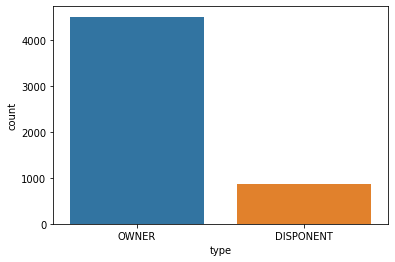

In [12]:
sns.countplot(data1['type'])

The plot shows us that there are 4 times more owners than disponents. Let's drop all the disponent rows.

In [13]:
data1.drop(data1[data1['type'] == 'DISPONENT'].index, inplace = True)
data1.head()

,account_id,district_id,frequency,date,disp_id,client_id,type
0,1,18,POPLATEK MESICNE,1995-03-24,1,1,OWNER
1,2,1,POPLATEK MESICNE,1993-02-26,2,2,OWNER
3,3,5,POPLATEK MESICNE,1997-07-07,4,4,OWNER
5,4,12,POPLATEK MESICNE,1996-02-21,6,6,OWNER
6,5,15,POPLATEK MESICNE,1997-05-30,7,7,OWNER


Now, let's merge this dataset with the loan table. We will do an inner join as we only want clients who took a loan.

In [14]:
data2 = pd.merge(data1,loan,on='account_id',how='inner',suffixes=('_acct','_loan')) #suffixes for date
data2

,account_id,district_id,frequency,date_acct,disp_id,client_id,type,loan_id,date_loan,amount,duration,payments,status
0,2,1,POPLATEK MESICNE,1993-02-26,2,2,OWNER,4959,1994-01-05,80952,24,3373,A
1,19,21,POPLATEK MESICNE,1995-04-07,25,25,OWNER,4961,1996-04-29,30276,12,2523,B
2,25,68,POPLATEK MESICNE,1996-07-28,31,31,OWNER,4962,1997-12-08,30276,12,2523,A
3,37,20,POPLATEK MESICNE,1997-08-18,45,45,OWNER,4967,1998-10-14,318480,60,5308,D
4,38,19,POPLATEK TYDNE,1997-08-08,46,46,OWNER,4968,1998-04-19,110736,48,2307,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,11327,7,POPLATEK MESICNE,1997-10-15,13615,13923,OWNER,7294,1998-09-27,39168,24,1632,C
678,11328,54,POPLATEK MESICNE,1996-11-05,13616,13924,OWNER,7295,1998-07-18,280440,60,4674,C
679,11349,1,POPLATEK TYDNE,1995-05-26,13647,13955,OWNER,7304,1995-10-29,419880,60,6998,C
680,11359,61,POPLATEK MESICNE,1994-10-01,13660,13968,OWNER,7305,1996-08-06,54024,12,4502,A


Great! Now we have date, amount, payment, duration and status of the loan for each client. Before exploring let's join the client table which will tell us gender and birthday of each client.

In [15]:
data3 = pd.merge(data2,client,on='client_id',how='inner',suffixes=('_bank','_client')) 
data3

,account_id,district_id_bank,frequency,date_acct,disp_id,client_id,type,loan_id,date_loan,amount,duration,payments,status,gender,birth_date,district_id_client
0,2,1,POPLATEK MESICNE,1993-02-26,2,2,OWNER,4959,1994-01-05,80952,24,3373,A,M,1945-02-04,1
1,19,21,POPLATEK MESICNE,1995-04-07,25,25,OWNER,4961,1996-04-29,30276,12,2523,B,F,1939-04-23,21
2,25,68,POPLATEK MESICNE,1996-07-28,31,31,OWNER,4962,1997-12-08,30276,12,2523,A,M,1962-02-09,68
3,37,20,POPLATEK MESICNE,1997-08-18,45,45,OWNER,4967,1998-10-14,318480,60,5308,D,M,1952-08-26,20
4,38,19,POPLATEK TYDNE,1997-08-08,46,46,OWNER,4968,1998-04-19,110736,48,2307,C,F,1940-01-30,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,11327,7,POPLATEK MESICNE,1997-10-15,13615,13923,OWNER,7294,1998-09-27,39168,24,1632,C,F,1979-02-22,7
678,11328,54,POPLATEK MESICNE,1996-11-05,13616,13924,OWNER,7295,1998-07-18,280440,60,4674,C,F,1952-09-09,54
679,11349,1,POPLATEK TYDNE,1995-05-26,13647,13955,OWNER,7304,1995-10-29,419880,60,6998,C,F,1945-10-30,1
680,11359,61,POPLATEK MESICNE,1994-10-01,13660,13968,OWNER,7305,1996-08-06,54024,12,4502,A,M,1968-04-13,61


Time for some visualization! Let's see the relationship of loan amount with duration based on the client's gender.

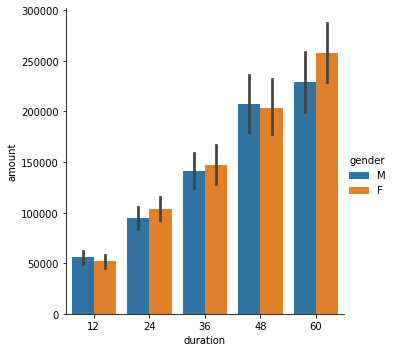

In [16]:
sns.catplot(x="duration", y="amount", hue="gender", kind="bar", data=data3)

As expected, large loan amounts were taken with longer payment period and it's true for both males and females. Let's find the same relationship based on the loan status. But what do those A,B,C,D mean actually? From the dataset guide:

    'A' stands for contract finished, no problems,
    'B' stands for contract finished, loan not payed,
    'C' stands for running contract, OK so far,
    'D' stands for running contract, client in debt.

So we can say, A and C are good status while B and D are bad status.

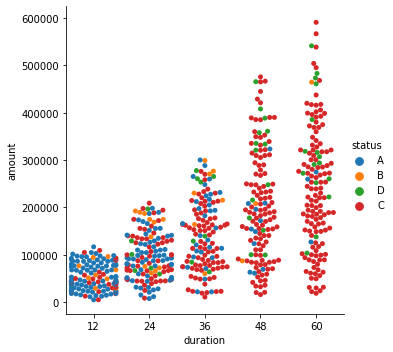

In [17]:
sns.catplot(x="duration", y="amount", hue="status", kind="swarm", data=data3)

Now this swarmplot makes a lot of sense. We see mostly and red and then blue points which represent C and A loan statuses respectively. So, we can say, most of the clients have a good loan status and normally small amounts are paid fully and contract is finished (blue points); large amounts are mostly running contracts with longer duration and are in good condition (red points). Therefore,  the bank is actually doing well as they have more good clients in terms of loan. Let's see the exact number.

In [18]:
print(data3['status'].value_counts().to_string())

C    403
A    203
D     45
B     31


So, if we take the status of loan as the target variable for the ML model, there will be a huge class imbalance. We can ask for more loan data from the bank to alleviate this problem. 

Now, I want to know all the client's age and see at what age most people ask for a loan. In order to do that, I will need to change the date columns to datetime objects so that I can easily perform arithmetic operations on them.

In [19]:
#Code to convert dates to datetime objects
data3.date_acct = pd.to_datetime(data3['date_acct'], format='%Y-%m-%d')
data3.date_loan = pd.to_datetime(data3['date_loan'], format='%Y-%m-%d')
data3.birth_date = pd.to_datetime(data3['birth_date'], format='%Y-%m-%d')

Now I can simply get a client's age when he/she took the loan by subtracting their birthday from the loan taking date.

In [20]:
data3['age_loan']= data3.date_loan - data3.birth_date
data3['age_loan'] = data3['age_loan'].dt.days/365

In [21]:
data3.head()

,account_id,district_id_bank,frequency,date_acct,disp_id,client_id,type,loan_id,date_loan,amount,duration,payments,status,gender,birth_date,district_id_client,age_loan
0,2,1,POPLATEK MESICNE,1993-02-26,2,2,OWNER,4959,1994-01-05,80952,24,3373,A,M,1945-02-04,1,48.950685
1,19,21,POPLATEK MESICNE,1995-04-07,25,25,OWNER,4961,1996-04-29,30276,12,2523,B,F,1939-04-23,21,57.057534
2,25,68,POPLATEK MESICNE,1996-07-28,31,31,OWNER,4962,1997-12-08,30276,12,2523,A,M,1962-02-09,68,35.852055
3,37,20,POPLATEK MESICNE,1997-08-18,45,45,OWNER,4967,1998-10-14,318480,60,5308,D,M,1952-08-26,20,46.164384
4,38,19,POPLATEK TYDNE,1997-08-08,46,46,OWNER,4968,1998-04-19,110736,48,2307,C,F,1940-01-30,19,58.257534


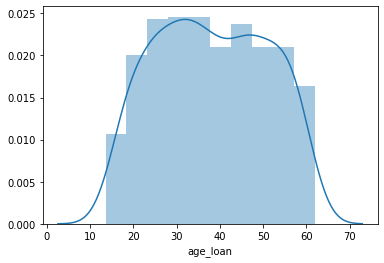

In [22]:
sns.distplot(data3['age_loan'])

As seen from this plot, most people took loan on their thirties.

Let's join the card table to see how the card type relates to the loan taking behavior.

In [23]:
data4 = pd.merge(data3,card,on='disp_id',how='left',suffixes=('_disp','_card')) # suffices for type
data4

,account_id,district_id_bank,frequency,date_acct,disp_id,client_id,type_disp,loan_id,date_loan,amount,duration,payments,status,gender,birth_date,district_id_client,age_loan,card_id,type_card,issued
0,2,1,POPLATEK MESICNE,1993-02-26,2,2,OWNER,4959,1994-01-05,80952,24,3373,A,M,1945-02-04,1,48.950685,NaN,NaN,NaN
1,19,21,POPLATEK MESICNE,1995-04-07,25,25,OWNER,4961,1996-04-29,30276,12,2523,B,F,1939-04-23,21,57.057534,NaN,NaN,NaN
2,25,68,POPLATEK MESICNE,1996-07-28,31,31,OWNER,4962,1997-12-08,30276,12,2523,A,M,1962-02-09,68,35.852055,NaN,NaN,NaN
3,37,20,POPLATEK MESICNE,1997-08-18,45,45,OWNER,4967,1998-10-14,318480,60,5308,D,M,1952-08-26,20,46.164384,NaN,NaN,NaN
4,38,19,POPLATEK TYDNE,1997-08-08,46,46,OWNER,4968,1998-04-19,110736,48,2307,C,F,1940-01-30,19,58.257534,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,11327,7,POPLATEK MESICNE,1997-10-15,13615,13923,OWNER,7294,1998-09-27,39168,24,1632,C,F,1979-02-22,7,19.608219,NaN,NaN,NaN
678,11328,54,POPLATEK MESICNE,1996-11-05,13616,13924,OWNER,7295,1998-07-18,280440,60,4674,C,F,1952-09-09,54,45.884932,NaN,NaN,NaN
679,11349,1,POPLATEK TYDNE,1995-05-26,13647,13955,OWNER,7304,1995-10-29,419880,60,6998,C,F,1945-10-30,1,50.030137,NaN,NaN,NaN
680,11359,61,POPLATEK MESICNE,1994-10-01,13660,13968,OWNER,7305,1996-08-06,54024,12,4502,A,M,1968-04-13,61,28.334247,1247.0,classic,1995-06-13


In [24]:
#No need for card id and issue date for our model. Let's drop them
data4.drop(['card_id','issued'], axis=1, inplace=True)

In [25]:
data4.head()

,account_id,district_id_bank,frequency,date_acct,disp_id,client_id,type_disp,loan_id,date_loan,amount,duration,payments,status,gender,birth_date,district_id_client,age_loan,type_card
0,2,1,POPLATEK MESICNE,1993-02-26,2,2,OWNER,4959,1994-01-05,80952,24,3373,A,M,1945-02-04,1,48.950685,NaN
1,19,21,POPLATEK MESICNE,1995-04-07,25,25,OWNER,4961,1996-04-29,30276,12,2523,B,F,1939-04-23,21,57.057534,NaN
2,25,68,POPLATEK MESICNE,1996-07-28,31,31,OWNER,4962,1997-12-08,30276,12,2523,A,M,1962-02-09,68,35.852055,NaN
3,37,20,POPLATEK MESICNE,1997-08-18,45,45,OWNER,4967,1998-10-14,318480,60,5308,D,M,1952-08-26,20,46.164384,NaN
4,38,19,POPLATEK TYDNE,1997-08-08,46,46,OWNER,4968,1998-04-19,110736,48,2307,C,F,1940-01-30,19,58.257534,NaN


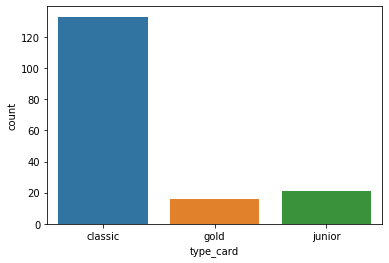

In [26]:
sns.countplot(data4['type_card'])

We can conclude that, mostly classic members asked for a loan. Let's check by the loan status.

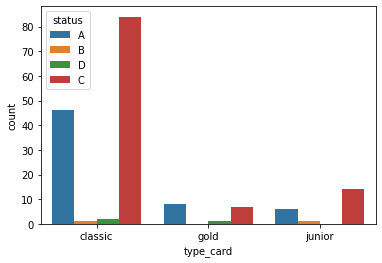

In [27]:
sns.countplot(data4['type_card'], hue=data4['status'])

No gold card member has a 'B' status while no junior card member has a 'D' status. As, 'B' and 'D' are bad loan status, we should see high payments from these two groups. Let's check. 

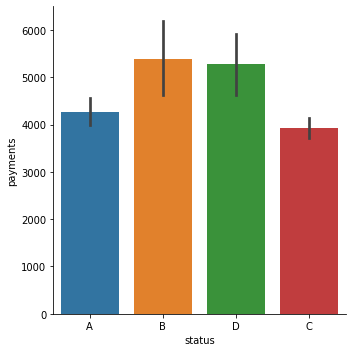

In [28]:
sns.catplot(x="status", y="payments", kind="bar", data=data4)

So, the assumption was right. Now time to clean this table to make it ready for the loan predictor ML model. First, let's drop unnecessary id columns and also the 'type_disp' column as it only contains one value = 'Owner'.

In [29]:
#drop id columns
columns = ['account_id','district_id_bank','district_id_client','disp_id','client_id','loan_id','type_disp']
data4.drop(columns, axis=1, inplace=True)

In [30]:
data4

,frequency,date_acct,date_loan,amount,duration,payments,status,gender,birth_date,age_loan,type_card
0,POPLATEK MESICNE,1993-02-26,1994-01-05,80952,24,3373,A,M,1945-02-04,48.950685,NaN
1,POPLATEK MESICNE,1995-04-07,1996-04-29,30276,12,2523,B,F,1939-04-23,57.057534,NaN
2,POPLATEK MESICNE,1996-07-28,1997-12-08,30276,12,2523,A,M,1962-02-09,35.852055,NaN
3,POPLATEK MESICNE,1997-08-18,1998-10-14,318480,60,5308,D,M,1952-08-26,46.164384,NaN
4,POPLATEK TYDNE,1997-08-08,1998-04-19,110736,48,2307,C,F,1940-01-30,58.257534,NaN
...,...,...,...,...,...,...,...,...,...,...,...
677,POPLATEK MESICNE,1997-10-15,1998-09-27,39168,24,1632,C,F,1979-02-22,19.608219,NaN
678,POPLATEK MESICNE,1996-11-05,1998-07-18,280440,60,4674,C,F,1952-09-09,45.884932,NaN
679,POPLATEK TYDNE,1995-05-26,1995-10-29,419880,60,6998,C,F,1945-10-30,50.030137,NaN
680,POPLATEK MESICNE,1994-10-01,1996-08-06,54024,12,4502,A,M,1968-04-13,28.334247,classic


Secondly, the date columns can be changed to integer values so that the model can use them.

In [31]:
data4.date_acct = data4.date_acct.view('int64')
data4.date_loan = data4.date_loan.view('int64')
data4.birth_date = data4.birth_date.view('int64')

Thirdly, the categorical columns can be converted to binary columns

In [32]:
catvars = ['frequency','type_card'] 
data4 = pd.concat([data4, pd.get_dummies(data4[catvars], prefix=catvars)], axis=1)
data4.drop(catvars,1,inplace=True)

In [33]:
data4

,date_acct,date_loan,amount,duration,payments,status,gender,birth_date,age_loan,frequency_POPLATEK MESICNE,frequency_POPLATEK PO OBRATU,frequency_POPLATEK TYDNE,type_card_classic,type_card_gold,type_card_junior
0,730684800000000000,757728000000000000,80952,24,3373,A,M,-785980800000000000,48.950685,1,0,0,0,0,0
1,797212800000000000,830736000000000000,30276,12,2523,B,F,-968630400000000000,57.057534,1,0,0,0,0,0
2,838512000000000000,881539200000000000,30276,12,2523,A,M,-249091200000000000,35.852055,1,0,0,0,0,0
3,871862400000000000,908323200000000000,318480,60,5308,D,M,-547516800000000000,46.164384,1,0,0,0,0,0
4,870998400000000000,892944000000000000,110736,48,2307,C,F,-944265600000000000,58.257534,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,876873600000000000,906854400000000000,39168,24,1632,C,F,288489600000000000,19.608219,1,0,0,0,0,0
678,847152000000000000,900720000000000000,280440,60,4674,C,F,-546307200000000000,45.884932,1,0,0,0,0,0
679,801446400000000000,814924800000000000,419880,60,6998,C,F,-762825600000000000,50.030137,0,0,1,0,0,0
680,780969600000000000,839289600000000000,54024,12,4502,A,M,-54259200000000000,28.334247,1,0,0,1,0,0


Finally, we can create the target column 'status' where A & C are good values (1) and B & D are bad values(0). Also, let's convert the gender column to 1 and 0. 

In [34]:
data4.loc[data4['status'].isin(['A','C']),'status'] = 1  # good
data4.loc[data4['status'].isin(['B','D']),'status'] = 0  # bad

data4.loc[data4['gender'].isin(['M']),'gender'] = 0  
data4.loc[data4['gender'].isin(['F']),'gender'] = 1  

In [35]:
data = data4
data #Final Dataset for the ML model

,date_acct,date_loan,amount,duration,payments,status,gender,birth_date,age_loan,frequency_POPLATEK MESICNE,frequency_POPLATEK PO OBRATU,frequency_POPLATEK TYDNE,type_card_classic,type_card_gold,type_card_junior
0,730684800000000000,757728000000000000,80952,24,3373,1,0,-785980800000000000,48.950685,1,0,0,0,0,0
1,797212800000000000,830736000000000000,30276,12,2523,0,1,-968630400000000000,57.057534,1,0,0,0,0,0
2,838512000000000000,881539200000000000,30276,12,2523,1,0,-249091200000000000,35.852055,1,0,0,0,0,0
3,871862400000000000,908323200000000000,318480,60,5308,0,0,-547516800000000000,46.164384,1,0,0,0,0,0
4,870998400000000000,892944000000000000,110736,48,2307,1,1,-944265600000000000,58.257534,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,876873600000000000,906854400000000000,39168,24,1632,1,1,288489600000000000,19.608219,1,0,0,0,0,0
678,847152000000000000,900720000000000000,280440,60,4674,1,1,-546307200000000000,45.884932,1,0,0,0,0,0
679,801446400000000000,814924800000000000,419880,60,6998,1,1,-762825600000000000,50.030137,0,0,1,0,0,0
680,780969600000000000,839289600000000000,54024,12,4502,1,0,-54259200000000000,28.334247,1,0,0,1,0,0


Now, we can use this 'data' table as the input of our ML model for loan status prediction.